In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pymc3 as pm
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
sns.set()

# ガウシアン推定

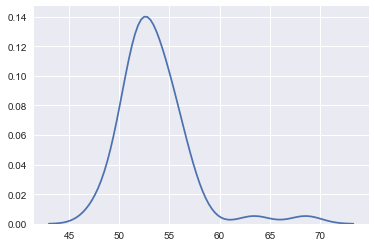

In [5]:
# Gauss分布に従うと想定される実験結果

data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

sns.kdeplot(data)

## 母平均と母分散を推定する

In [7]:
with pm.Model() as model_g:
    mu=pm.Uniform('mu',lower=40,upper=70) # upperとlowerの間にあると仮定
    sigma=pm.HalfNormal('sigma',sd=10) # 半正規分布を仮定
    
    # 事後分布のモデルを構築
    y=pm.Normal('y',mu=mu,sd=sigma,observed=data)
    start=pm.find_MAP()
    trace_g=pm.sample(1100,start=start)

logp = -155.3, ||grad|| = 39.05: 100%|██████████| 9/9 [00:00<00:00, 1485.41it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 6400/6400 [00:01<00:00, 3409.73draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117317400>,
      dtype=object)

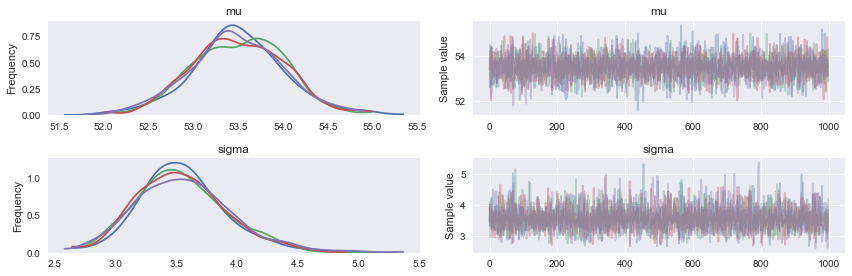

In [9]:
chain_g=trace_g[100:]
pm.traceplot(chain_g)

In [10]:
pm.summary(chain_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.491939,0.512362,0.008025,52.436030,54.446839,4043.221027,1.000122
sigma,3.553013,0.377501,0.006079,2.854478,4.320298,3336.966483,0.999980


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1173ee080>,
      dtype=object)

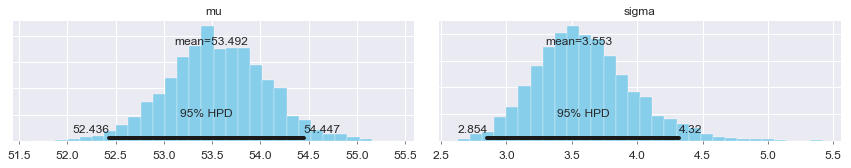

In [12]:
pm.plot_posterior(chain_g)

## 事後分布から、100組の予測値を導出

100%|██████████| 100/100 [00:00<00:00, 1209.43it/s]
/Users/hiroaki/.pyenv/versions/3.6.5/envs/pycoon365/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


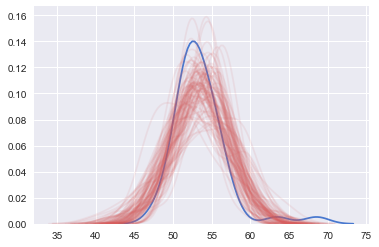

In [27]:
y_pred=pm.sample_ppc(chain_g,100,model_g,size=len(data))
sns.kdeplot(data,c='b')
for i in y_pred['y']:
    sns.kdeplot(i[0],c='r',alpha=0.1)

In [25]:
y_pred['y'][99]

array([[54.66076098, 54.27777559, 52.10869946, ..., 48.77017861,
        53.36475568, 48.87344845],
       [54.31452431, 56.84699296, 50.58738372, ..., 45.90761941,
        68.72916699, 48.09487334],
       [55.11131317, 53.65068255, 52.84661852, ..., 61.47141008,
        52.89479963, 55.77902234],
       ...,
       [58.93176176, 50.43223061, 52.17372998, ..., 59.33001242,
        55.52187543, 54.27961706],
       [55.70412202, 56.48852346, 52.871429  , ..., 57.86529621,
        53.62325933, 53.33714928],
       [58.26389556, 46.4220928 , 52.43311856, ..., 50.94553078,
        50.43310631, 64.53870846]])